In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from game.Bankgames import *
from game.plotting import *
from game.distributions import TruncatedGaussian, Uniform, PiecewiseUniform
import nashpy as nh
from tqdm import tqdm
from utils.project_dirs import *
from game.run_game import *

In [3]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 17,                   # Set font size to 11pt
    'axes.labelsize': 20,               # -> axis labels
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'legend.fontsize': 18,
    'lines.linewidth':2,
    'text.usetex': False,
    'pgf.rcfonts': False,
})

In [2]:
# fixed gammas, changing mu and sigma for truncated gaussian to search for epsilon signs
# truncated gaussian results in ++, +-, -+; not - +
import numpy as np
from itertools import product

def search_eps_signs():
    gamma_values = [0.4, 0.8]
    mu_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    sigma_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,  0.7, 0.8, 0.9]
#     sigma_values = np.linspace(0.1, 0.9, 6)  # Sigma in [0,1]

    found_cases = {}

    # Iterate over all possible combinations
    for gamma_l, gamma_h, mu, sigma in product(gamma_values, gamma_values, mu_values, sigma_values):
        if gamma_l >= gamma_h:  # Ensure gamma_l < gamma_h
            continue
        
        taus = sorted([1 / (2 + gamma) for gamma in [gamma_l, gamma_h]])
        tg = TruncatedGaussian(mu=mu, sigma=sigma)
        gtm = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=tg)
        
        eps1, eps2 = gtm.eps1, gtm.eps2
        sign_pair = (np.sign(eps1), np.sign(eps2))

        # Store unique cases for each sign combination
        if sign_pair not in found_cases:
            found_cases[sign_pair] = (gamma_l, gamma_h, mu, sigma, eps1, eps2)

        # Stop early if we found all sign cases
        if len(found_cases) == 4:
            break
    
    # Print results
    for sign_pair, values in found_cases.items():
        gamma_l, gamma_h, mu, sigma, eps1, eps2 = values
        print(f"Sign: {sign_pair}, γ_l: {gamma_l}, γ_h: {gamma_h}, μ: {mu}, σ: {sigma}, eps1: {eps1}, eps2: {eps2}")

# Run the search
search_eps_signs()

Sign: (np.float64(1.0), np.float64(1.0)), γ_l: 0.4, γ_h: 0.8, μ: 0.1, σ: 0.1, eps1: 0.00020692814488667806, eps2: 0.000281050405330507
Sign: (np.float64(1.0), np.float64(-1.0)), γ_l: 0.4, γ_h: 0.8, μ: 0.1, σ: 0.2, eps1: 0.0022268793930812734, eps2: -0.0036150576433734713
Sign: (np.float64(-1.0), np.float64(-1.0)), γ_l: 0.4, γ_h: 0.8, μ: 0.1, σ: 0.3, eps1: -0.011946914670527095, eps2: -0.03468944104610684


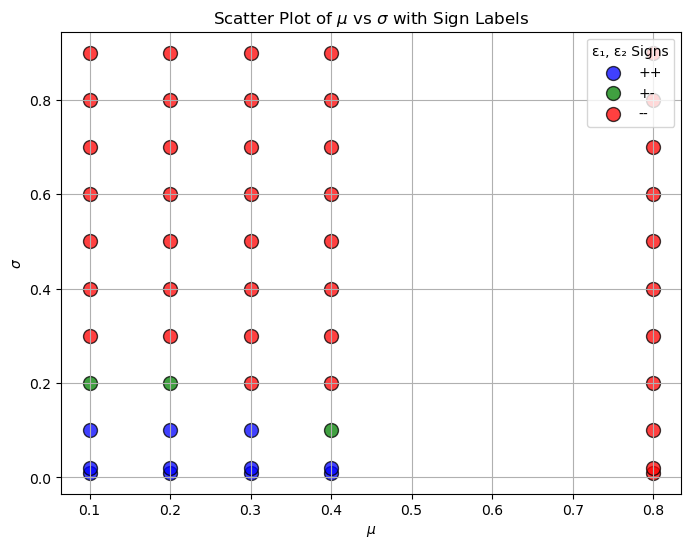

In [69]:
def search_eps_signs():
    gamma_values = [0.4, 0.8]
    mu_values = [0.1, 0.2, 0.3, 0.4, 0.8]
    sigma_values = [0.01, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,  0.7, 0.8, 0.9]

    sign_cases = []

    # Iterate over all possible combinations
    for gamma_l, gamma_h, mu, sigma in product(gamma_values, gamma_values, mu_values, sigma_values):
        if gamma_l >= gamma_h:  # Ensure gamma_l < gamma_h
            continue
        
        taus = sorted([1 / (2 + gamma) for gamma in [gamma_l, gamma_h]])
        tg = TruncatedGaussian(mu=mu, sigma=sigma)
        gtm = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=tg)
        
        eps1, eps2 = gtm.eps1, gtm.eps2
        sign_pair = (np.sign(eps1), np.sign(eps2))

        # Convert sign pair to string format for consistent mapping
        label = f"{'+' if sign_pair[0] > 0 else '-'}{'+' if sign_pair[1] > 0 else '-'}"
        sign_cases.append((mu, sigma, label))

    # Define fixed colors for each sign type
    sign_colors = {
        '++': 'blue',
        '--': 'red',
        '+-': 'green',
        '-+': 'orange'
    }

    # Plot scatter plot
    plt.figure(figsize=(8, 6))
    for mu, sigma, label in sign_cases:
        plt.scatter(mu, sigma, color=sign_colors[label], label=label, s=100, alpha=0.75, edgecolors='black')

    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\sigma$')
    plt.title('Scatter Plot of $\mu$ vs $\sigma$ with Sign Labels')

    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys(), title="ε₁, ε₂ Signs")

    plt.grid(True)
    plt.show()

# Run the search and plot
search_eps_signs()

In [60]:
def search_eps_signs():
    found_cases = {}
    gamma_values = [0.4, 0.8]
    for gamma_l, gamma_h in tqdm(product(gamma_values, gamma_values)):
        if gamma_l >= gamma_h:
            continue
        taus = sorted([1 / (2 + gamma) for gamma in [gamma_l, gamma_h]])
        puf = PiecewiseUniform(ga_l = gamma_l, ga_h = gamma_h)
        gtm = GameTrueMatrix2by2(gammas=[gamma_l, gamma_h], taus=taus, dist=puf)
        
        eps1, eps2 = gtm.eps1, gtm.eps2
        sign_pair = (np.sign(eps1), np.sign(eps2))

        # Store unique cases for each sign combination
        if sign_pair not in found_cases:
            found_cases[sign_pair] = (gamma_l, gamma_h, eps1, eps2)

        # Stop early if we found all sign cases
        if len(found_cases) == 4:
            break
    
    # Print results
    for sign_pair, values in found_cases.items():
        gamma_l, gamma_h, eps1, eps2 = values
        print(f"Sign: {sign_pair}, γ_l: {gamma_l:.2f}, γ_h: {gamma_h:.2f}, eps1: {eps1:.4f}, eps2: {eps2:.4f}")

# Run the search
search_eps_signs()

4it [00:00, 86.81it/s]

Sign: (np.float64(1.0), np.float64(1.0)), γ_l: 0.40, γ_h: 0.80, eps1: 0.0313, eps2: 0.0652


In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_sem_over_time(dist_data, labels, save_dir, T_end=None, title_prefix="", savefile_prefix=""):
    """
    Plots the mean and standard error of the mean (SEM) over time for multiple distance metrics.

    Parameters:
    - dist_data: dict {label -> pd.Series} where each series contains numpy arrays of shape (num_experiments, num_rounds)
    - labels: list of str, names for each metric (used in titles and legends)
    - save_dir: str, directory where plots will be saved
    - T_end: int, maximum number of rounds to consider (plots only the first T_end iterations)
    - title_prefix: str, prefix for the plot titles
    - savefile_prefix: str, prefix for the saved filenames (e.g., 'truemat', 'freshmat', 'movingmat')
    """
    colors = ["C0", "C1"]  # Different colors for different banks

    os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists

    for (label, series), color in zip(dist_data.items(), colors):
        # Convert to numpy array (shape: num_experiments x num_rounds)
        data = np.array([row[:T_end] if T_end else row for row in series])

        num_experiments, num_rounds = data.shape
        rounds = np.arange(num_rounds)  # Time steps

        # Compute mean and SEM
        mean_dist = np.mean(data, axis=0)
        sem_dist = np.std(data, axis=0) / np.sqrt(num_experiments)

        # Plot mean with shaded SEM region
        plt.figure(figsize=(10, 5))
        plt.plot(rounds, mean_dist, label=f"{label}", linewidth=2, color=color)
        plt.fill_between(rounds, mean_dist - sem_dist, mean_dist + sem_dist, color=color, alpha=0.2)

        # Labels and title
        plt.xlabel("Round")
        plt.ylabel("L2 Distance to NE")
        plt.title(f"{title_prefix} {label}")
        plt.legend()
        plt.grid(alpha=0.3)

        # Generate filename with prefix
        filename = f"{savefile_prefix}_{label.replace(' ', '_')}.pdf"
        save_path = os.path.join(save_dir, filename)

        # Save figure
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        plt.close()



In [25]:
# import os
# def plot_mean_sem_over_time(dist_data, labels, save_dir, T_end=None, title_prefix="", savefile_prefix = ''):
#     """
#     Plots the mean and standard error of the mean (SEM) over time for multiple distance metrics.

#     Parameters:
#     - dist_data: dict {label -> pd.Series} where each series contains numpy arrays of shape (num_experiments, num_rounds)
#     - labels: list of str, names for each metric (used in titles and legends)
#     - save_dir: str, directory where plots will be saved
#     - T_end: int, maximum number of rounds to consider (plots only the first T_end iterations)
#     - title_prefix: str, prefix for the plot titles
#     """
#     colors = ["C0", "C1"]  # Different colors for different banks

#     os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists

#     for (label, series), color in zip(dist_data.items(), colors):
#         # Convert to numpy array (shape: num_experiments x num_rounds)
#         data = np.array([row[:T_end] if T_end else row for row in series])

#         num_experiments, num_rounds = data.shape
#         rounds = np.arange(num_rounds)  # Time steps

#         # Compute mean and SEM
#         mean_dist = np.mean(data, axis=0)
#         sem_dist = np.std(data, axis=0) / np.sqrt(num_experiments)

#         # Plot mean with shaded SEM region
#         plt.figure(figsize=(10, 5))
#         plt.plot(rounds, mean_dist, label=f"{label}", linewidth=2, color=color)
#         plt.fill_between(rounds, mean_dist - sem_dist, mean_dist + sem_dist, color=color, alpha=0.2)

#         # Labels and title
#         plt.xlabel("Rounds")
#         plt.ylabel("L2 Distance")
#         plt.title(f"{title_prefix} {label}")
#         plt.legend()
#         plt.grid(alpha=0.3)

#         # Save figure
#         save_path = os.path.join(save_dir, f"{label.replace(' ', '_')}.pdf") # add savefile_prefix (it's either truemat, freshmat, movingmat)
#         plt.savefig(save_path, bbox_inches="tight", dpi=300)
#         plt.close()

# # Example Usage:
# plot_mean_sem_over_time(
#     {
#         "Bank1 iterates dist to NE": df['closestNEdist_knownmat_b1'],
#         "Bank2 iterates dist to NE": df['closestNEdist_knownmat_b2']
#     },
#     labels=["Bank1", "Bank2"],
#     save_dir="../plots/2gamma-distance/case++",
#     T_end=20000  # Adjust T_end as needed
# )

## Epsilon_1 > 0, Epsilon_2 >0 (Case ++)

## Single symmetric NE is that both banks have strategy (tau_l, gamma_h)

In [11]:
T = 100000
eta = 0.1

In [6]:
gammas = sorted([0.4, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.3
sigma = 0.1
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1 and epsilon2

0.010332909480748565 0.005169944765989978


In [7]:
# epsigns = f'sign{gtm.eps_case}'
# save_dir = saved_df_2gamma(epsigns=epsigns)

In [8]:
tg.name, gtm.instance_name, gtm.eps_case

('TG_mu0.3_sigma0.1', 'TG_mu0.3_sigma0.1[0.4, 0.8]++', '++')

In [9]:
display(len(gtm.NE_theory), gtm.NE_theory) # this is what theory gives us
display(len(gtm.NE_se), gtm.NE_se) 
# this is from running nashpy directly on the utility matrices, note in nashpy row players strat i.e. B2 appears first

1

[[[0, 1, 0, 0], [0, 1, 0, 0]]]

1

[(array([0., 1., 0., 0.]), array([0., 1., 0., 0.]))]

In [10]:
save_dir_full, save_dir_conc = saved_df_n_dist_full_T(n=2, distribution='truncated_gaussian', T=T),\
                                saved_df_n_dist_concise_T(n=2, distribution='truncated_gaussian', T=T)

## Code below runs hedge on all 3 games
- with the known matrix
- with the fresh matrix
- with the moving average matrix

And initializes 5 different random probability vectors for both banks (seed set for reproducibility)

In [14]:
%%time

df_pp, df_conc_pp = run_across_init_2gamma(gtm, save_dir_full, save_dir_conc, \
                                     num_startprofiles=5, T=T, eta=eta, seed=21)

100%|█████████████████████████████████████████████| 5/5 [04:53<00:00, 58.77s/it]


CPU times: user 4min 47s, sys: 4.5 s, total: 4min 52s
Wall time: 4min 54s


In [15]:
df_pp.columns, df_conc_pp.columns #across 5 different random starting vectors for both banks

(Index(['instance_name', 'dist', 'gammas', 'taus', 'eps_case', 'Bank1_start',
        'Bank2_start', 'hedgeT', 'NE_theory', 'NE_nashpy', 'numberof_NE',
        'Bank1iter_knownmat', 'Bank2iter_knownmat', 'closestNE_knownmat',
        'closestNEdist_knownmat', 'closestNEdist_knownmat_b1',
        'closestNEdist_knownmat_b2', 'Bank1iter_fresh1', 'Bank2iter_fresh1',
        'closestNE_fresh1', 'closestNEdist_fresh1', 'closestNEdist_fresh1_b1',
        'closestNEdist_fresh1_b2', 'Bank1iter_moving1', 'Bank2iter_moving1',
        'closestNE_moving1', 'closestNEdist_moving1',
        'closestNEdist_moving1_b1', 'closestNEdist_moving1_b2'],
       dtype='object'),
 Index(['instance_name', 'dist', 'gammas', 'taus', 'eps_case', 'Bank1_start',
        'Bank2_start', 'hedgeT', 'NE_theory', 'NE_nashpy', 'numberof_NE',
        'closestNE_knownmat', 'closestNEdist_knownmat', 'closestNE_fresh1',
        'closestNEdist_fresh1', 'closestNE_moving1', 'closestNEdist_moving1'],
       dtype='object'))

In [16]:
df_pp['closestNE_knownmat'], df_pp['closestNE_fresh1'], df_pp['closestNE_moving1']

(0    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 1    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 2    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 3    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 4    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_knownmat, dtype: object,
 0    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 1    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 2    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 3    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 4    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_fresh1, dtype: object,
 0    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 1    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 2    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 3    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 4    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_moving1, dtype: object)

In [37]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, known matrix": df_pp['closestNEdist_knownmat_b1'],
        "Bank2 distance to NE, known matrix": df_pp['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case++",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="truemat"  # Example prefix
)

In [38]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, fresh estimate": df_pp['closestNEdist_fresh1_b1'],
        "Bank2 distance to NE, fresh estimate": df_pp['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case++",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="freshmat"  # Example prefix
)

In [39]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, moving estimate": df_pp['closestNEdist_moving1_b1'],
        "Bank2 distance to NE, moving estimate": df_pp['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case++",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="movingmat"  # Example prefix
)

## Epsilon_1 < 0, Epsilon_2 < 0  (Case --)

## Single symmetric NE is that both banks have strategy (tau_h, gamma_l)

In [40]:
T = 20000
eta = 0.1

In [41]:
save_dir_full, save_dir_conc = saved_df_n_dist_full_T(n=2, distribution='truncated_gaussian', T=T),\
                                saved_df_n_dist_concise_T(n=2, distribution='truncated_gaussian', T=T)

In [42]:
gammas = sorted([0.4, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.1
sigma = 0.3
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1<0 and epsilon2<0

-0.011946914670527095 -0.03468944104610684


In [43]:
display(len(gtm.NE_theory), gtm.NE_theory) # this is what theory gives us
display(len(gtm.NE_se), gtm.NE_se) 
# this is from running nashpy directly on the utility matrices, note in nashpy row players strat i.e. B2 appears first

1

[[[0, 0, 1, 0], [0, 0, 1, 0]]]

1

[(array([0., 0., 1., 0.]), array([0., 0., 1., 0.]))]

In [44]:
# save directory for dataframe 
# TODO
# instance_name = f'Tg_mu{mu}_sig{sigma}_gamma{str(gammas)}.pkl' # truncated gaussian
# epsigns = f'sign{gtm.eps_case}'
# save_dir = saved_df_2gamma(epsigns=epsigns)

In [45]:
df_mm, df_conc_mm = run_across_init_2gamma(gtm, save_dir_full, save_dir_conc, \
                                     num_startprofiles=5, T=T, eta=eta, seed=21)

100%|█████████████████████████████████████████████| 5/5 [00:58<00:00, 11.63s/it]


In [74]:
df_conc

,instance_name,dist,gammas,taus,eps_case,Bank1_start,Bank2_start,closestNE_knownmat,closestNEdist_knownmat,closestNE_fresh1,closestNEdist_fresh1,closestNE_moving1,closestNEdist_moving1
0,"TG_mu0.1_sigma0.3[0.4, 0.8]",TG_mu0.1_sigma0.3,"[0.4, 0.8]","[0.35714285714285715, 0.4166666666666667]",--,"[0.04872488080912729, 0.24038477898068955, 0.4...","[0.021616249915949792, 0.029157006779427008, 0...","([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000003,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000003,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000002
1,"TG_mu0.1_sigma0.3[0.4, 0.8]",TG_mu0.1_sigma0.3,"[0.4, 0.8]","[0.35714285714285715, 0.4166666666666667]",--,"[0.30227189396461684, 0.005842499272261992, 0....","[0.06957095461260054, 0.5140203216059982, 0.28...","([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000015,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000009,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000015
2,"TG_mu0.1_sigma0.3[0.4, 0.8]",TG_mu0.1_sigma0.3,"[0.4, 0.8]","[0.35714285714285715, 0.4166666666666667]",--,"[0.13324051925174774, 0.04488414230775062, 0.3...","[0.7589438355121143, 0.10475580904610926, 0.10...","([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000117,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000076,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000121
3,"TG_mu0.1_sigma0.3[0.4, 0.8]",TG_mu0.1_sigma0.3,"[0.4, 0.8]","[0.35714285714285715, 0.4166666666666667]",--,"[0.3842500320901294, 0.02446829735360312, 0.35...","[0.27066977267313375, 0.442690655211345, 0.140...","([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000056,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000085,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000061
4,"TG_mu0.1_sigma0.3[0.4, 0.8]",TG_mu0.1_sigma0.3,"[0.4, 0.8]","[0.35714285714285715, 0.4166666666666667]",--,"[0.5166685377580662, 0.24408753190653998, 0.15...","[0.16783576522150734, 0.1161072798091265, 0.01...","([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000523,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000708,"([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])",0.000571


In [46]:
df_conc_mm['closestNE_knownmat'], df_conc_mm['closestNE_fresh1'], df_conc_mm['closestNE_moving1']

(0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 Name: closestNE_knownmat, dtype: object,
 0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 Name: closestNE_fresh1, dtype: object,
 0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 Name: closestNE_moving1, dtype: object)

In [47]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, known matrix": df_mm['closestNEdist_knownmat_b1'],
        "Bank2 distance to NE, known matrix": df_mm['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case--",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="truemat"  # Example prefix
)

In [48]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, fresh estimate": df_mm['closestNEdist_fresh1_b1'],
        "Bank2 distance to NE, fresh estimate": df_mm['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case--",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="freshmat"  # Example prefix
)

In [49]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, moving estimate": df_mm['closestNEdist_moving1_b1'],
        "Bank2 distance to NE, moving estimate": df_mm['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case--",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="movingmat"  # Example prefix
)

## Epsilon_1 > 0, Epsilon_2 < 0 (Case +-)

## 3 NE for utiltiy matrix
 - 1 pure symmetric both (tau_l, gamma_h)
 - 1 pure symmetric both (tau_h, gamma_l)
 - 1 mixed symmetric ([0,c,1-c,0], [0,c,1-c,0])

In [50]:
gammas = sorted([0.4, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])
mu = 0.1
sigma = 0.2
tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=tg)
print(gtm.eps1, gtm.eps2) # epsilon1 and epsilon2

0.0022268793930812734 -0.0036150576433734713


In [52]:
display(len(gtm.NE_theory), gtm.NE_theory) # this is what theory gives us
display(len(gtm.NE_se), gtm.NE_se) 
# this is from running nashpy directly on the utility matrices, note in nashpy row players strat i.e. B2 appears first

3

[[[0, 0, 1, 0], [0, 0, 1, 0]],
 [[0, 1, 0, 0], [0, 1, 0, 0]],
 [[0, 0.6188114696914494, 0.3811885303085506, 0],
  [0, 0.6188114696914494, 0.3811885303085506, 0]]]

3

[(array([0., 1., 0., 0.]), array([0., 1., 0., 0.])),
 (array([0., 0., 1., 0.]), array([0., 0., 1., 0.])),
 (array([0.        , 0.61881147, 0.38118853, 0.        ]),
  array([0.        , 0.61881147, 0.38118853, 0.        ]))]

In [40]:
# save directory for dataframe
# instance_name = f'Tg_mu{mu}_sig{sigma}_gamma{str(gammas)}.pkl' # truncated gaussian
# epsigns = 'sign+-'
# save_path = str(saved_df_2gamma(epsigns=epsigns) / instance_name)
# print(save_path)

/Users/krishna/Documents/Research/BankGame/bankgame/notebooks/../saved_df/2_gamma/sign+-/Tg_mu0.1_sig0.2_gamma[0.4, 0.8].pkl


In [53]:
save_dir_full, save_dir_conc = saved_df_n_dist_full_T(n=2, distribution='truncated_gaussian', T=T),\
                                saved_df_n_dist_concise_T(n=2, distribution='truncated_gaussian', T=T)

In [54]:
T = 20000
eta = 0.1

df_pm, df_conc_pm = run_across_init_2gamma(gtm, save_dir_full, save_dir_conc, \
                                     num_startprofiles=5, T=T, eta=eta, seed=21)

100%|█████████████████████████████████████████████| 5/5 [00:57<00:00, 11.50s/it]


In [77]:
df_conc_pm['closestNE_knownmat'], df_conc_pm['closestNE_fresh1'], df_conc_pm['closestNE_moving1']

(0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_knownmat, dtype: object,
 0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_fresh1, dtype: object,
 0    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 4    ([0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_moving1, dtype: object)

In [55]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, known matrix": df_pm['closestNEdist_knownmat_b1'],
        "Bank2 distance to NE, known matrix": df_pm['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case+-",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="truemat"  # Example prefix
)

In [56]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, fresh estimate": df_pm['closestNEdist_fresh1_b1'],
        "Bank2 distance to NE, fresh estimate": df_pm['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case+-",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="freshmat"  # Example prefix
)

In [57]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, moving estimate": df_pm['closestNEdist_moving1_b1'],
        "Bank2 distance to NE, moving estimate": df_pm['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case+-",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="movingmat"  # Example prefix
)

##  eps_1<0 eps_2>0  (Case -+, )

Here is where we needed to use the **piecewise uniform**, because trunc gaussian never resulted in epsilon -+ across parameters

3 NE
-  1 pure asymetric [(tau_l, gamma_h), (tau_h, gamma_l)]
 - 1 pure asymmetric [(tau_h, gamma_l), (tau_l, gamma_h)]
 - 1 mixed symmetric ([0,c,1-c,0], [0,c,1-c,0])

In [58]:
gammas = sorted([0.6, 0.7])
taus = sorted([1/(2+gamma) for gamma in gammas])
puf = PiecewiseUniform(ga_l = gammas[0], ga_h = gammas[1]) #needs exactly these gamma_l and high values
gtm = GameTrueMatrix2by2(gammas=gammas, taus=taus, dist=puf)

gtm.eps1,gtm.eps2

(-0.005480769254716564, 0.002269230769230711)

In [59]:
display(len(gtm.NE_theory), gtm.NE_theory)

display(len(gtm.NE_se), gtm.NE_se)

3

[[[0, 1, 0, 0], [0, 0, 1, 0]],
 [[0, 0, 1, 0], [0, 1, 0, 0]],
 [[0, 0.2928039702233183, 0.7071960297766817, 0],
  [0, 0.2928039702233183, 0.7071960297766817, 0]]]

3

[(array([0., 1., 0., 0.]), array([0., 0., 1., 0.])),
 (array([0., 0., 1., 0.]), array([0., 1., 0., 0.])),
 (array([0.        , 0.29280397, 0.70719603, 0.        ]),
  array([0.        , 0.29280397, 0.70719603, 0.        ]))]

In [133]:
# # save directory for dataframe
# instance_name = f'Punif_gamma{str(gammas)}.pkl' # truncated gaussian
# epsigns = 'sign-+'
# save_path = str(saved_df_2gamma(epsigns=epsigns) / instance_name)
# print(save_path)

In [60]:
save_dir_full, save_dir_conc = saved_df_n_dist_full_T(n=2, distribution='piecewise_uniform', T=T),\
                                saved_df_n_dist_concise_T(n=2, distribution='piecewise_uniform', T=T)

In [61]:
T = 20000
eta = 0.1

df_mp, df_conc_mp = run_across_init_2gamma(gtm, save_dir_full, save_dir_conc, \
                                     num_startprofiles=5, T=T, eta=eta, seed=21)

100%|█████████████████████████████████████████████| 5/5 [00:40<00:00,  8.07s/it]


In [62]:
df_conc_mp['closestNE_knownmat'], df_conc_mp['closestNE_fresh1'], df_conc_mp['closestNE_moving1'] # Epic, shows different asymmetric based on starting

(0    ([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_knownmat, dtype: object,
 0    ([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_fresh1, dtype: object,
 0    ([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0])
 1    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 2    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 3    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 4    ([0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0])
 Name: closestNE_moving1, dtype: object)

In [63]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, known matrix": df_mp['closestNEdist_knownmat_b1'],
        "Bank2 distance to NE, known matrix": df_mp['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case-+",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="truemat"  # Example prefix
)

In [64]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, fresh estimate": df_mp['closestNEdist_fresh1_b1'],
        "Bank2 distance to NE, fresh estimate": df_mp['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case-+",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="freshmat"  # Example prefix
)

In [65]:
plot_mean_sem_over_time(
    {
        "Bank1 distance to NE, moving estimate": df_mp['closestNEdist_moving1_b1'],
        "Bank2 distance to NE, moving estimate": df_mp['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"],
    save_dir="../plots/2gamma-distance/case-+",
    T_end=20000,  # Adjust T_end as needed
    savefile_prefix="movingmat"  # Example prefix
)